In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision.transforms as transforms
import torchvision
import torchvision.models 
from torchmetrics import TotalVariation

import copy
from PIL import Image
import matplotlib.pyplot as plt

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.device(device)

device(type='cpu')

## Load Image to perform style transfer with the method proposed by Gatys et al.

In [4]:
# simple than using the actual dataloading (as the functionality is the same without any wrappers)
transform = transforms.Compose([
    transforms.Resize(256),  
    transforms.CenterCrop((256, 256)),
    transforms.ToTensor()
    ]
)

def load_img(name):
    img = Image.open(name)
    img = torch.reshape(transform(img), (1, 3, 256, 256))
    return img.to(device, torch.float)


style_img = load_img("./style_images/style5.jpg")
content_img = load_img("./test_images/test1.jpg")

## Display

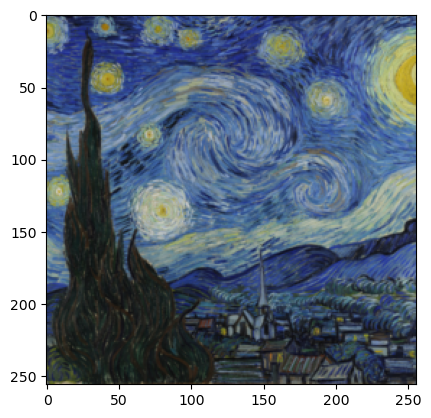

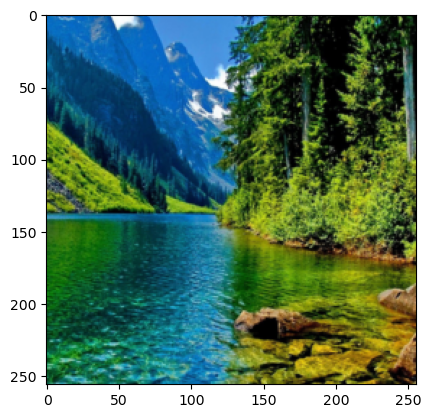

In [5]:
def show_img(tensor):
    plt.figure()
    img = tensor.cpu().clone()  # need to clone the tensor to not do changes on it
    image = torch.reshape(img, (3, 256, 256)) 
    image = transforms.ToPILImage()(image)
    plt.imshow(image)
    plt.show()

show_img(style_img)
show_img(content_img)

# Loss

In [6]:
from src.loss import LossCalculator

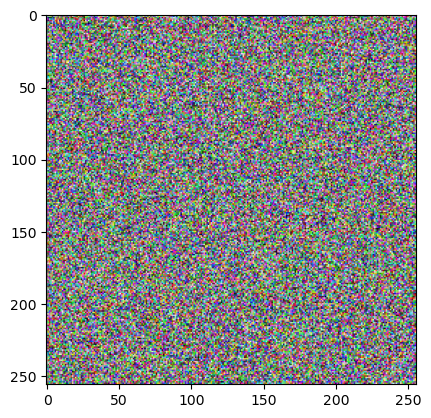

In [7]:
# input_img = content_img.clone() # clone the content image as the start image to optimize
input_img = torch.randn(1, 3, 256, 256).to(device)
input_img.requires_grad_(True)

show_img(input_img)

Run: 50 	 Loss : 26.194786
Run: 100 	 Loss : 18.543772
Run: 150 	 Loss : 13.786835
Run: 200 	 Loss : 10.679677
Run: 250 	 Loss : 8.954921
Run: 300 	 Loss : 8.065386


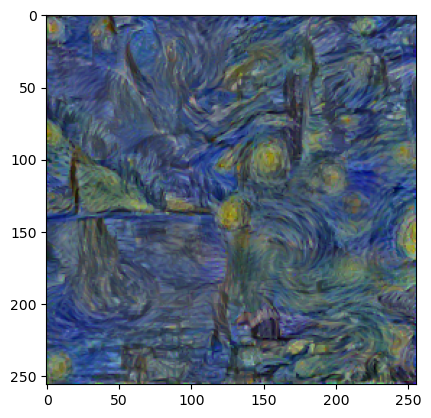

In [8]:
# a simple demo of style transfer with the method proposed by Gatys et al.
# demonstrates why the method is not suitable for real-time style transfer
def style_transfer(content_img, style_img, input_img, iterations=300,
                       style_factor=100, content_factor=1):
    lc = LossCalculator()
    optimizer = optim.LBFGS([input_img])
    
    steps = 0
    while steps <= iterations:

        optimizer.zero_grad()
        loss = lc.calculate_loss(content_factor, style_factor, 1e-4, input_img, style_img, content_img)
        loss.backward()

        steps += 1
        if steps % 50 == 0:
            print("Run: {} \t Loss : {:2f}".format(steps, loss.item()))

        optimizer.step(lambda: loss)
        
        with torch.no_grad(): 
            input_img.clamp_(0, 1) #always keep the input image in the range [0,1]

    return input_img

output = style_transfer(content_img, style_img, input_img)

show_img(output)

# Now the style transfer CNN approach

In [9]:
from src.architecture import ImageTransformNet

# DEMO that takes a webcam stream and performs style transfer in real time.

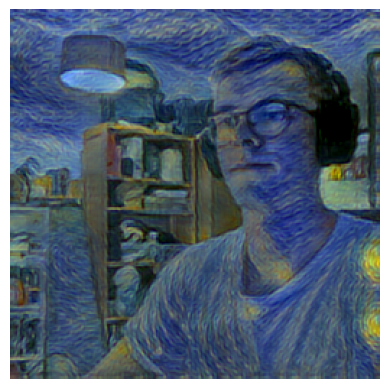

FPS: 2.654581


In [11]:
# source: https://stackoverflow.com/questions/2601194/displaying-a-webcam-feed-using-opencv-and-python/11449901#11449901
import cv2
import torch
import PIL.Image as Image
import torchvision.transforms as transforms
from matplotlib.animation import FuncAnimation
import numpy as np

import time

device = torch.device("cpu")

import cv2
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

pretrained_filename = "./checkpoints/<class 'src.models.johnson_model.JohnsonsImageTransformNet'>--2023-08-03_16-22-39vanGogh--up--in--vgg16--1-25-1e-5--allreflect--longer--end.pth"
pretrained_filename = "./checkpoints/<class 'src.models.johnson_model.JohnsonsImageTransformNet'>--2023-08-03_21-08-55vanGogh--up--in--vgg16--1-250-1e-5--allreflect--end--ownloss.pth"

model = ImageTransformNet()
model.load_state_dict(torch.load(pretrained_filename, map_location=device))
model = model.to(device)
# take frame from webcam
vc = cv2.VideoCapture(0)
frame_counter = 0
start_time = time.time()

if vc.isOpened(): # try to get the first frame
    rval, frame = vc.read()
else:
    print("Webcam not found")

try:

    while time.time() - start_time < 10:
        clear_output(wait=True)
        
        frame_counter += 1
        rval, frame = vc.read()
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame_pil = Image.fromarray(frame)
        model_input = transform(frame_pil)
        model_input = model_input.unsqueeze(0).to(device)

        frame_out = model(model_input).squeeze(0)
        frame_out = torch.clamp(frame_out, 0, 1)
        frame_out = frame_out.permute(1, 2, 0).cpu().detach().numpy()
    
        plt.imshow(frame_out)
        plt.axis('off')
        plt.show()
        
except Exception as e:
    print(e)

vc.release()

print("FPS: {:2f}".format(frame_counter / (time.time() - start_time)))

In [12]:
# if the above cell is stopped, run this cell to release the camera
vc.release()